In [24]:
from tqdm import tqdm
import wandb
api = wandb.Api(timeout=180)
import os
import pandas as pd
import wandb
import yaml
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import itertools
import  matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import time
import matplotlib as mpl
import matplotlib.ticker as ticker


In [25]:
USER='wilderlavington' 
PROJECT='FunctionalOptimizationFinal'
SUMMARY_FILE='FuncOptSVMlib.csv'  
try:
    os.makedirs("plots/aistats/")
except FileExistsError:
    print("File already exists")

File already exists


In [26]:
%run plotting_utils.py

In [27]:
download_wandb_summary(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

100%|███████████████████████████████████████| 5462/5462 [14:16<00:00,  6.38it/s]


In [28]:
download_wandb_records(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (12,43,46,49,54,57,59,61,71,72,123,139) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|███████████████████████████████████████| 5462/5462 [52:15<00:00,  1.74it/s]


,Unnamed: 0,name,id,c,m,algo,loss,seed,group,label,entity,log_lr,log_dir,outer_c,project,episodes,file_name,fullbatch,inner_opt,batch_size,min_epochs,beta_update,folder_name,gulf2_alpha,matfac_xdim,matfac_ydim,dataset_name,eta_schedule,expand_coeff,min_episodes,init_step_size,matfac_nsamples,gulf2_prox_steps,randomize_folder,reset_lr_on_step,outer_beta_update,use_optimal_stepsize,matfac_condition_number,normalize_epochs_lengths,beta,cuda,clamp,l2_reg,nonlin,epsilon,use_sgd,env_name,bandwidth,ftrl_clip,loss_type,max_procs,use_exact,add_l2_reg,log_lambda,model_type,static_cov,expert_mode,expert_type,hidden_size,kernel_type,replay_size,ftrl_variant,log_inner_lr,log_interval,log_outer_lr,offline_wandb,multi_seed_run,transform_dist,mini_batch_size,sls_beta_update,epochs_per_update,trust_region_type,inner_policy_optim,samples_per_update,stochastic_interaction,_step,grad_norm,function_evals+grad_evals,inner_backtracks,avg_loss,eta_scale,_timestamp,grad_evals,inner_steps,inner_step_size,_runtime,step_time,optim_steps,time_elapsed,function_evals,_wandb,update,policy_loss,log_avg_optimal_regret,inclass_regret,inclass_return,expert_loss,expert_return,policy_return,optimal_regret,ogd_loss,log_policy_loss,optimal_return,total_examples,avg_inclass_regret,avg_optimal_regret,log_optimal_regret,beta.1,log_avg_inclass_regret,log_inclass_regret,eta,sso_ogd_loss,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0,skilled-wave-813,5ntbw9by,0.1,1000,Ada_FMDOpt,CrossEntropyLoss,2,main,workshop-fig14,wilderlavington,4,./wandb,0.5,FunctionalOptimizationFinal,100.0,example,1.0,LSOpt,100.0,500.0,0.9,examples/,0.3,6.0,10.0,mnist,constant,2.0,1.0,1.0,1000.0,25.0,1.0,1.0,0.9,0,1.000000e-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,235.071213,0.0,0.0,16.422319,10000.00,1.666125e+09,0.0,0.0,NaN,0.910960,NaN,0.0,0.339421,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,d,3,2,5,1,4,e,a,e,7,1,8,7,b,b,4,3,6,c,e,1,1,3,7,a,c,8,a,d,1,e,c,4,9,9,4,e,d,d
1,0,skilled-wave-813,5ntbw9by,0.1,1000,Ada_FMDOpt,CrossEntropyLoss,2,main,workshop-fig14,wilderlavington,4,./wandb,0.5,FunctionalOptimizationFinal,100.0,example,1.0,LSOpt,100.0,500.0,0.9,examples/,0.3,6.0,10.0,mnist,constant,2.0,1.0,1.0,1000.0,25.0,1.0,1.0,0.9,0,1.000000e-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.570218,0.0,0.0,0.561666,10000.00,1.666125e+09,1000.0,1000.0,NaN,0.910960,NaN,1.0,47.160980,7693.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,d,3,2,5,1,4,e,a,e,7,1,8,7,b,b,4,3,6,c,e,1,1,3,7,a,c,8,a,d,1,e,c,4,9,9,4,e,d,d
0,1,denim-cloud-812,pgwnaep8,0.1,100,Ada_FMDOpt,CrossEntropyLoss,2,main,workshop-fig14,wilderlavington,5,./wandb,0.5,FunctionalOptimizationFinal,100.0,example,1.0,LSOpt,100.0,500.0,0.9,examples/,0.3,6.0,10.0,mnist,constant,2.0,1.0,1.0,1000.0,25.0,1.0,1.0,0.9,0,1.000000e-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,235.071213,1008.0,0.0,16.422319,100000.00,1.666125e+09,0.0,0.0,1.0,6.261475,00:00:04.85,0.0,0.487494,0.0,{'runtime': 10},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,d,3,2,5,1,4,e,a,e,7,1,8,7,b,b,4,3,6,c,e,1,1,3,7,a,c,8,a,d,1,e,c,4,9,9,4,e,d,d
1,1,denim-cloud-812,pgwnaep8,0.1,100,Ada_FMDOpt,CrossEntropyLoss,2,main,workshop-fig14,wilderlavington,5,./wandb,0.5,FunctionalOptimizationFinal,100.0,example,1.0,LSOpt,100.0,500.0,0.9,examples/,0.3,6.0,10.0,mnist,constant,2.0,1.0,1.0,1000.0,25.0,1.0,1.0,0.9,0,1.000000e-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,32

In [29]:
def generate_appendix_figure(loss, schedule, wandb_records, sso_algo, x ='optim_steps', y='avg_loss'):
    
    # base info   
    dataset_names = ['mushrooms', 'ijcnn', 'rcv1']
    batch_sizes = [25, 125, 625]
    m = [1, 5, 10, 20] 
    wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    # init plots 
    fig, axs = plt.subplots(len(dataset_names), len(batch_sizes)+1, figsize=(16, 8))
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD': '#44AA99' , 'SLS': '#DDCC77', 'Adam': '#88CCEE'}
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-5': '#AA4499', 'SSO-10': '#882255' , 'SSO-20': '#332288'})
    algorithms = ['SGD', 'Adam', 'SLS'] + ['SSO-'+str(m_) for m_ in m] 
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, dataset_name in enumerate(dataset_names):
        
        # figure out axis automatically 
        x_max = 0 

        # SLS
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SLS', 
                                         linestyle='dashed', color=colormap['SLS'])
        else:
            print('missing SLS  ', dataset_name, 'full-batch')

        # SGD
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SGD', 
                                         linestyle='dashed', color=colormap['SGD'])
        else:
            print('missing SGD  ', dataset_name, 'full-batch')
        
        # Adam
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
            'eta_schedule': 'constant', 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='Adam', 
                                         linestyle='dashed', color=colormap['Adam'])
        else:
            print('missing Adam  ', dataset_name, 'full-batch')
        
        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 1, 
                    'loss': loss, 'algo': sso_algo, 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1],  \
                                        label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
            else:
                print('missing FMDopt  ', m_, dataset_name, 'full-batch') 
        axs[row][-1].grid()     
        axs[row][-1].set_yscale("log")
        axs[row][-1].set_xscale("log") 
        
        # mini-batch plots 
        for col, batch_size in enumerate(batch_sizes):
            
            # figure out axis automatically 
            x_max = 0 
            
            # SLS
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'LSOpt',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SLS', 
                                             linestyle='dashed', color=colormap['SLS'])
            else:
                print('missing SLS  ', dataset_name, batch_size)
            
            # SGD
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, #'_step': 499.0,
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None: 
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SGD', 
                                             linestyle='dashed', color=colormap['SGD'])
            else:
                print('missing SGD  ', dataset_name, batch_size)
            
            # Adam
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, #'_step': 499.0,  
                'use_optimal_stepsize': 1, 'loss': loss, 'algo': 'Adam',
                'eta_schedule': 'constant', 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None: 
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='Adam', 
                                             linestyle='dashed', color=colormap['Adam'])
            else:
                print('missing Adam  ', dataset_name, batch_size)
    
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size,  
                        'use_optimal_stepsize': 1, #'_step': 499.0,
                        'loss': loss, 'algo': sso_algo, 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col=x, y_col=y)
                if proc_df is not None:
                    x_max = max(proc_df[x].values.max(), x_max)
                    axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                            label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
                else:
                    print('missing FMDopt  ', m_, dataset_name, batch_size) 
            
            axs[row][col].grid()     
            axs[row][col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
            axs[row][col].yaxis.set_major_locator(plt.MaxNLocator(4))
            axs[row][col].set_yscale("log")
            axs[row][col].set_xscale("log")
            axs[0][col].set_title('batch-size: '+str(batch_size), fontsize=22)
            axs[0][-1].set_title('full-batch', fontsize=22)
            axs[row][-1].set_ylabel(dataset_name, fontsize=22)
            axs[row][-1].yaxis.set_label_position("right") 
        
        axs[row][col].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,numticks=100))
        axs[row][col].xaxis.set_minor_formatter(mpl.ticker.NullFormatter()) 
        axs[row][col].yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
        
    # remaining format stuff  
    handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
    leg = fig.legend(handles=handles,
           loc="lower center",   # Position of legend
           borderaxespad=1.65,    # Small spacing around legend box
           # title="Algorithms",  # Title for the legend
           fontsize=18,
           ncol=7, 
           bbox_to_anchor=(0.525, -0.12),
           )
    
    plt.subplots_adjust(hspace=1.5)
    plt.rcParams['figure.dpi'] = 100# 400 
    fig.tight_layout()
    
    # show / save
    plt.savefig('plots/aistats/workshop-sls_sso-'+sso_algo+loss+schedule+'.pdf', bbox_inches='tight')
    plt.show() 

In [30]:
 wandb_records = pd.read_csv('logs/wandb_data/__full__'+SUMMARY_FILE, header=0, squeeze=True)

/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,44,47,50,55,58,60,62,72,73,87,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


constant


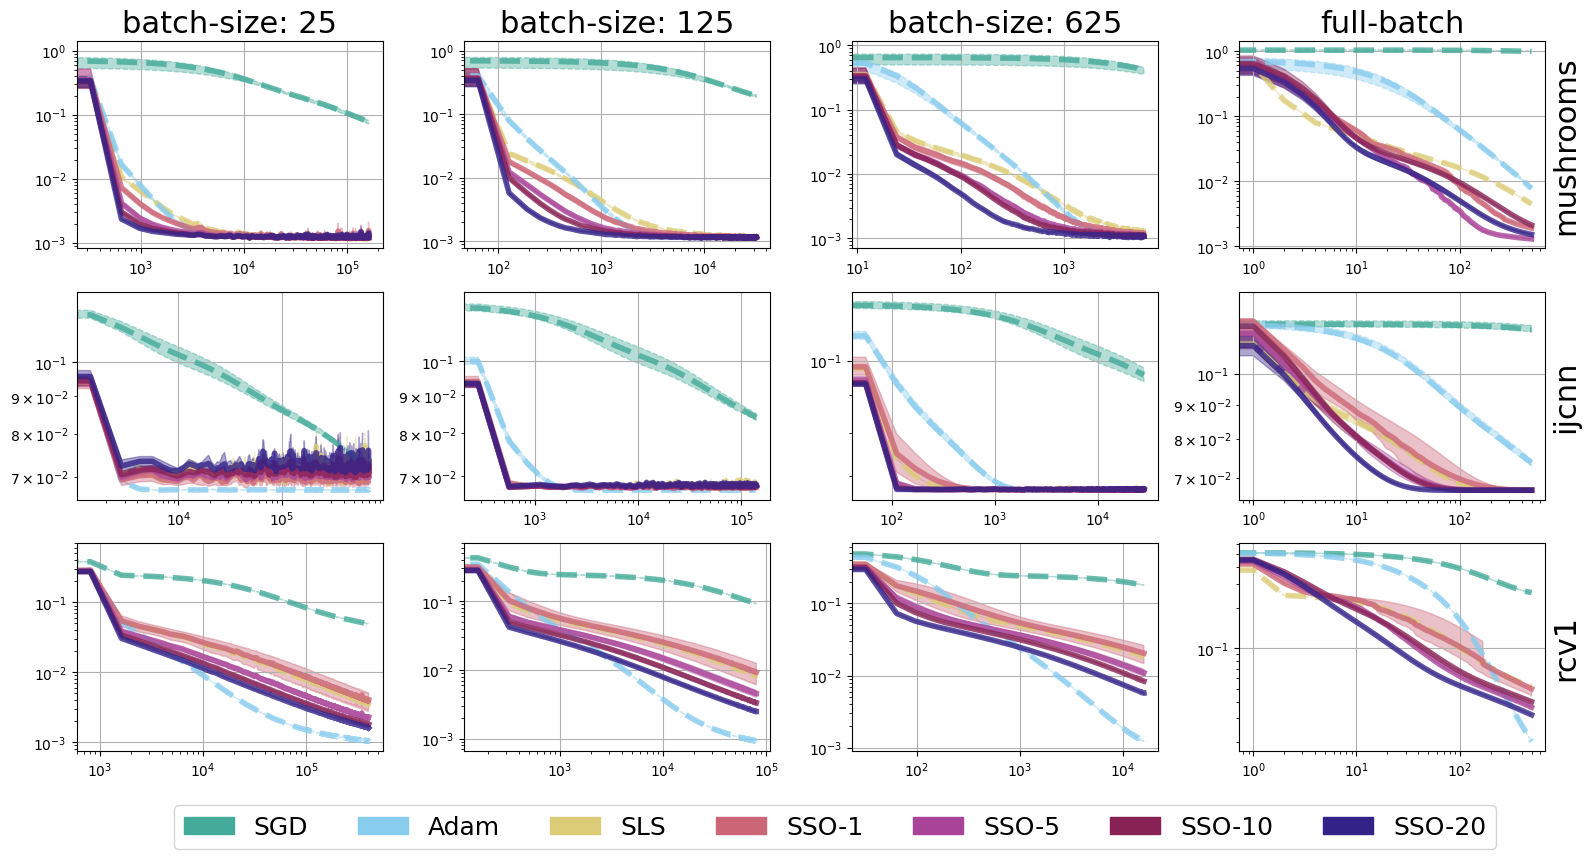

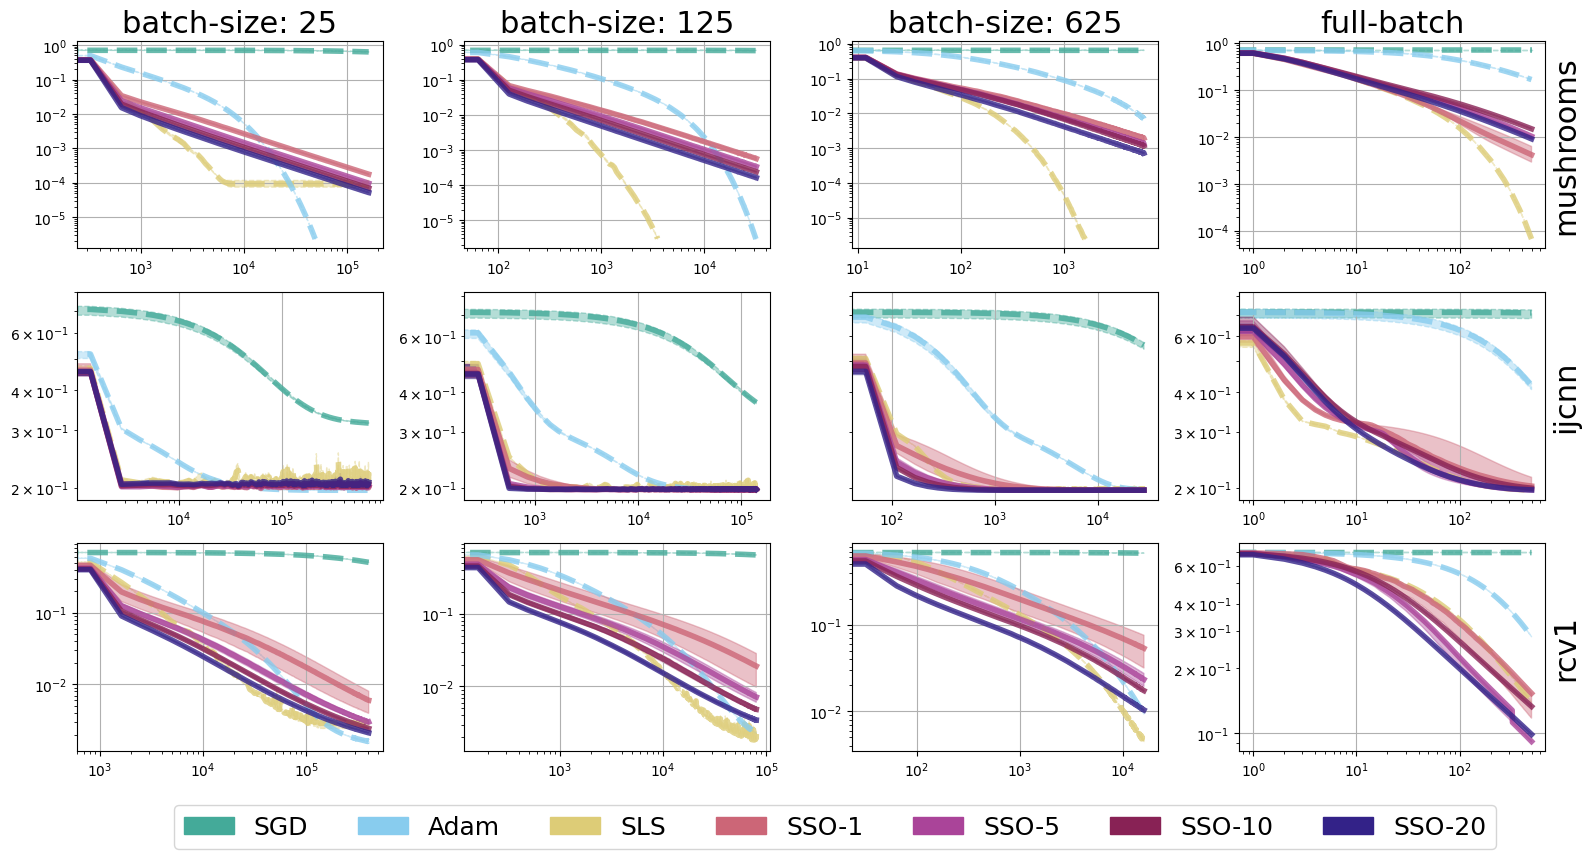

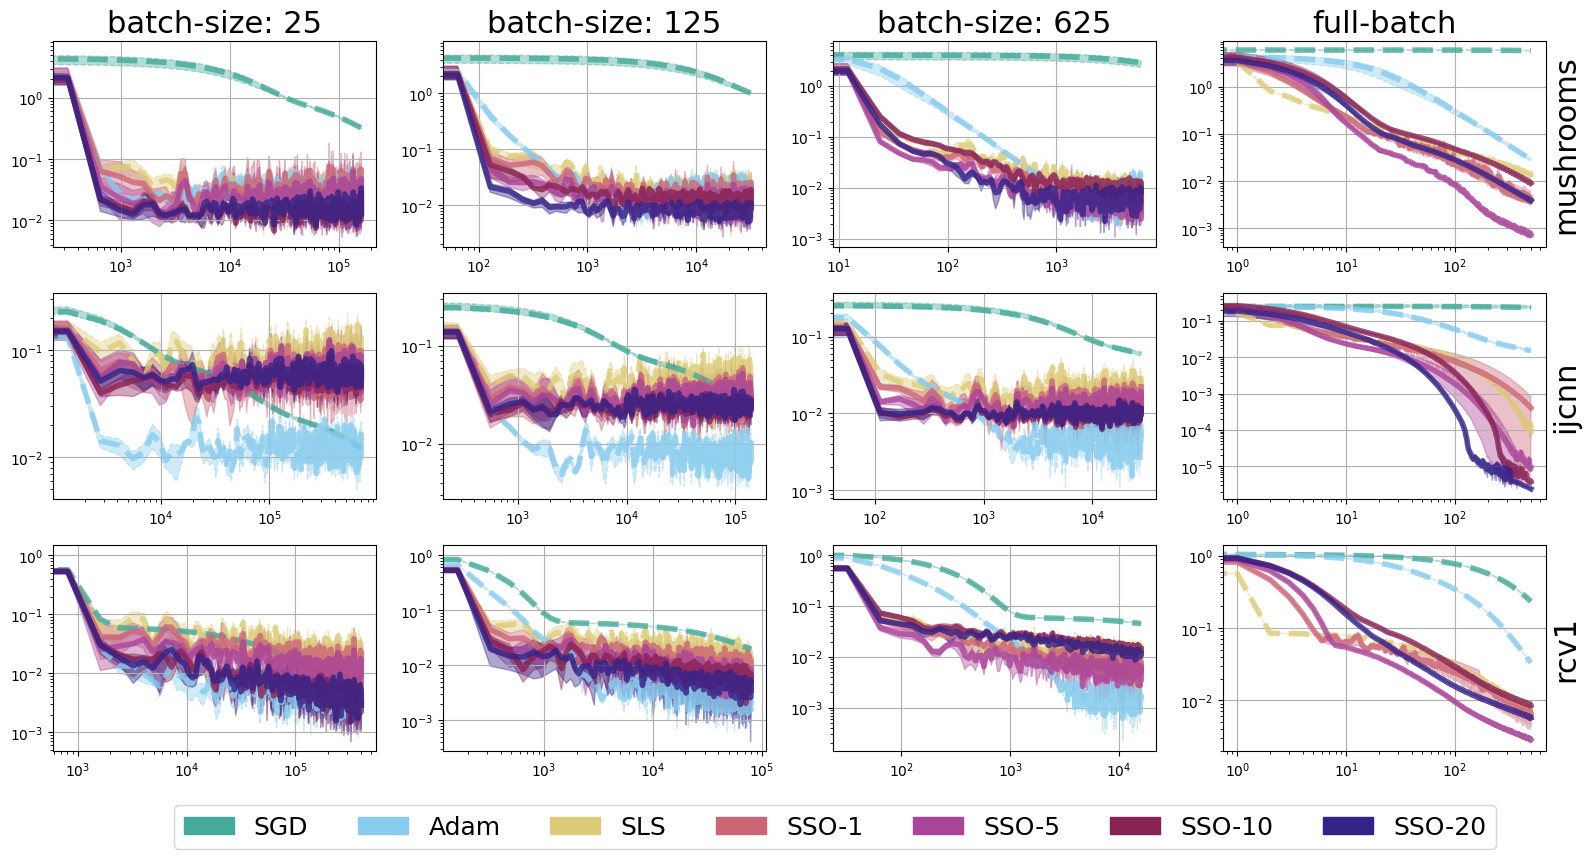

In [ ]:
#============================================================================================
# constant step-size decay
#============================================================================================
# loss comparison
print('constant')
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'SGD_FMDOpt',  x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'SGD_FMDOpt',x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'SGD_FMDOpt',  x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'SGD_FMDOpt', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

#============================================================================================
# stochastic step-size decay
#============================================================================================
# loss comparison
print('stochastic')
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'SGD_FMDOpt', x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'SGD_FMDOpt',  x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'SGD_FMDOpt',  x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'SGD_FMDOpt', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

#============================================================================================
# exponential step-size decay
#============================================================================================
# loss comparison
print('exponential')
generate_appendix_figure('MSELoss', 'exponential', wandb_records, 'SGD_FMDOpt',  x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'exponential', wandb_records, 'SGD_FMDOpt',  x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'exponential', wandb_records, 'SGD_FMDOpt',  x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'exponential', wandb_records, 'SGD_FMDOpt',  x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')


In [ ]:
#============================================================================================
# constant step-size decay
#============================================================================================
# loss comparison
print('constant')
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'SLS_FMDOpt',  x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'SGD_FMDOpt', x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'SLS_FMDOpt',  x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'SLS_FMDOpt',  x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

#============================================================================================
# stochastic step-size decay
#============================================================================================
# loss comparison
print('stochastic')
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'SLS_FMDOpt',  x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'SLS_FMDOpt',  x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'SGD_FMDOpt',  x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'SLS_FMDOpt',  x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

#============================================================================================
# exponential step-size decay
#============================================================================================
# loss comparison
print('exponential')
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'SLS_FMDOpt', x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'SLS_FMDOpt', x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'SGD_FMDOpt', x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'SLS_FMDOpt',  x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')


In [ ]:
#============================================================================================
# constant step-size decay
#============================================================================================
# loss comparison
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'Diag_Ada_FMDOpt',  x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'Diag_Ada_FMDOpt',  x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'Diag_Ada_FMDOpt',  x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'Diag_Ada_FMDOpt',  x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

 

In [ ]:
 #============================================================================================
# constant step-size decay
#============================================================================================
# loss comparison
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'Ada_FMDOpt', x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'Ada_FMDOpt', fig_name='a', x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'Ada_FMDOpt', x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'Ada_FMDOpt', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
 

In [ ]:
 #============================================================================================
# constant step-size decay
#============================================================================================
# loss comparison
print('constant')
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'constant', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'constant', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

#============================================================================================
# stochastic step-size decay
#============================================================================================
# loss comparison
print('stochastic')
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')

#============================================================================================
# exponential step-size decay
#============================================================================================
# loss comparison
print('exponential')
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x ='optim_steps', y='avg_loss')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x='optim_steps', y='avg_loss')
# grad-norm comparison
generate_appendix_figure('MSELoss', 'stochastic', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x ='optim_steps', y='grad_norm')
generate_appendix_figure('BCEWithLogitsLoss', 'stochastic', wandb_records, 'Online_Newton_FMDOpt', fig_name='a', x ='optim_steps', y='grad_norm')
# # time-elapsed comparison
# generate_sls_figure('MSELoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')
# generate_sls_figure('BCEWithLogitsLoss', 'constant', wandb_records, fig_name='a', x ='time_elapsed', y='avg_loss')